# Creating & Analyzing Equity Portfolios (with rebalancing)

__Objectives:__

-> Find out if active rebalancing where Weights are restored to initial/target weights at the end of each day will result in upward shift of efficient frontier
-  Doing so will result in selling daily winners and buying daily losers to restore original weights. Contrarian Trading Strategy

__Method:__

1. We import 'scipy.optimize', for python to optimise what we want, be it the maximum return portfolio, or the one with the lowest risk.
   - We use a constraint function, and a function to input what we want to maximize or minimize
   - We create 10,000 portfolios within the constraints given (what we want to do - be it maximise return or find one with lowest Risk or highest RaR) with differing weights and plot them using matplotlib
   - We plot the daily rebalanced portfolio and it's efficient frontier against the one that was not rebalanced to compare performance


__Key Learnings:__

1. To maximise RaR, the optimizer function returned that we should have:
   - 31.3% MSFT, 24.32% TSLA and 22.88% GE, 21.47% AAPL, none of the rest, as these 4 are on the efficient frontier.
   - The CAGR of this portfolio will be 40.75%!
   - The Volitility 27.27% (Standard Deviatoin)
   - Risk Adjsuted Return (RaR) at 1.49! 


2. Significant Rebalancing Costs eat up Rebalancing Benefits
   - Solution: Reduce Rebalacing Frequency to monthly/quarterly (reduces costs but also benefits)
   - Only rebalance if calculated rebalancing costs are lower than rebalancing benefits
     
3. Upward Shift of Efficient Frontier when balanced daily: (as could be seen with the 2 efficient frontiers!)
- equal risk & more return or
- equal return & less risk

4. As I was optimizing the past here:<br>
- Very unlikely we had selected this optimal portfolio back then (look ahead bias)! <br>
- Very unlikely this will be the optimal portfolio in the future (past performance is not a good indicator for future performance)!




## Getting started

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#5 year past data
start = '2019-09-09'
end = '2024-09-09'
symbol = ['AAPL', 'BA', 'DIS', 'GE', 'JPM', 'MSFT', 'TSLA', 'WMT']
df = yf.download(symbol, start, end ).Close
df

[*********************100%%**********************]  8 of 8 completed


Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-09,53.54,358.78,138.83,44.66,115.40,137.52,15.45,38.78
2019-09-10,54.17,369.49,135.79,45.55,116.87,136.08,15.70,38.68
2019-09-11,55.90,382.94,136.19,46.65,117.19,136.12,16.47,38.67
2019-09-12,55.77,375.63,137.50,46.15,117.91,137.52,16.39,38.97
2019-09-13,54.69,379.76,138.02,46.55,120.23,137.32,16.35,39.14
...,...,...,...,...,...,...,...,...
2024-08-30,229.00,173.74,90.38,174.62,224.80,417.14,214.11,77.23
2024-09-03,222.77,161.02,89.13,164.21,220.30,409.44,210.60,77.17
2024-09-04,220.85,163.22,89.25,166.36,219.33,408.90,219.41,77.24


In [72]:
returns = df.pct_change().dropna() 
returns

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-10,0.01,0.03,-0.02,0.02,0.01,-0.01,0.02,-0.00
2019-09-11,0.03,0.04,0.00,0.02,0.00,0.00,0.05,-0.00
2019-09-12,-0.00,-0.02,0.01,-0.01,0.01,0.01,-0.00,0.01
2019-09-13,-0.02,0.01,0.00,0.01,0.02,-0.00,-0.00,0.00
2019-09-16,0.01,-0.00,-0.02,0.00,-0.01,-0.01,-0.01,-0.02
...,...,...,...,...,...,...,...,...
2024-08-30,-0.00,0.01,0.01,0.01,0.01,0.01,0.04,0.01
2024-09-03,-0.03,-0.07,-0.01,-0.06,-0.02,-0.02,-0.02,-0.00
2024-09-04,-0.01,0.01,0.00,0.01,-0.00,-0.00,0.04,0.00


In [74]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2019-09-10 to 2024-09-06
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1257 non-null   float64
 1   BA      1257 non-null   float64
 2   DIS     1257 non-null   float64
 3   GE      1257 non-null   float64
 4   JPM     1257 non-null   float64
 5   MSFT    1257 non-null   float64
 6   TSLA    1257 non-null   float64
 7   WMT     1257 non-null   float64
dtypes: float64(8)
memory usage: 88.4 KB


In [76]:
def ann_risk_return(returns_df): # assumes simple returns as input
    summary = pd.DataFrame(index = returns_df.columns)
    summary["ann. Risk"] = returns_df.std() * np.sqrt(252)
    log_returns = np.log(returns_df + 1)
    summary["CAGR"] = np.exp(log_returns.mean() * 252) - 1
    return summary

In [78]:
summary = ann_risk_return(returns.iloc[1:])
summary

,ann. Risk,CAGR
Ticker,,
AAPL,0.32,0.33
BA,0.51,-0.16
DIS,0.34,-0.08
GE,0.40,0.29
JPM,0.32,0.13
MSFT,0.30,0.24
TSLA,0.66,0.68
WMT,0.22,0.15


## Creating Random Portfolios (Part 1)

In [82]:
noa = len(returns.columns) # number of assets
noa

8

In [84]:
nop = 10000 # number of random portfolios
nop


10000

In [86]:
# 80,000 random floats between 0 and 1
np.random.seed(123)
matrix = np.random.random(noa * nop).reshape(nop, noa)

In [88]:
matrix

array([[0.69646919, 0.28613933, 0.22685145, ..., 0.42310646, 0.9807642 ,
        0.68482974],
       [0.4809319 , 0.39211752, 0.34317802, ..., 0.0596779 , 0.39804426,
        0.73799541],
       [0.18249173, 0.17545176, 0.53155137, ..., 0.84943179, 0.72445532,
        0.61102351],
       ...,
       [0.1412533 , 0.28570045, 0.56403074, ..., 0.34359409, 0.87588094,
        0.78291379],
       [0.1896295 , 0.45365639, 0.82695243, ..., 0.91009298, 0.92561585,
        0.38263481],
       [0.84641632, 0.3538014 , 0.67855546, ..., 0.40234825, 0.42038566,
        0.91972547]])

In [90]:
matrix.shape

(10000, 8)

In [92]:
matrix.sum(axis = 1).reshape(10000)

array([4.56894411, 3.57956695, 4.24063404, ..., 3.82262761, 4.93698499,
       3.99183794])

In [94]:
weights = matrix / matrix.sum(axis = 1,keepdims= True) # make portfolio weights summing up to 1
weights

array([[0.15243548, 0.06262702, 0.04965074, ..., 0.09260487, 0.21465883,
        0.14988797],
       [0.13435477, 0.10954328, 0.09587138, ..., 0.01667182, 0.111199  ,
        0.20616891],
       [0.04303407, 0.04137394, 0.12534715, ..., 0.20030773, 0.17083656,
        0.14408777],
       ...,
       [0.03695189, 0.07473928, 0.14755053, ..., 0.08988427, 0.22913059,
        0.20481037],
       [0.03840998, 0.09188936, 0.16750151, ..., 0.18434186, 0.18748606,
        0.07750374],
       [0.21203674, 0.0886312 , 0.16998572, ..., 0.10079273, 0.10531131,
        0.2304015 ]])

In [96]:
weights.sum(axis = 1, keepdims= True)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [98]:
w1 = weights[0]
w1

array([0.15243548, 0.06262702, 0.04965074, 0.12066568, 0.15746942,
       0.09260487, 0.21465883, 0.14988797])

__Daily rebalancing of weights.__

In [101]:
returns.mul(w1).sum(axis = 1) # weighted average simple returns over time

Date
2019-09-10    0.01
2019-09-11    0.02
2019-09-12   -0.00
2019-09-13    0.00
2019-09-16   -0.01
              ... 
2024-08-30    0.01
2024-09-03   -0.03
2024-09-04    0.01
2024-09-05    0.01
2024-09-06   -0.03
Length: 1257, dtype: float64

In [103]:
port1 = returns.dot(w1) # dot product
port1

Date
2019-09-10    0.01
2019-09-11    0.02
2019-09-12   -0.00
2019-09-13    0.00
2019-09-16   -0.01
              ... 
2024-08-30    0.01
2024-09-03   -0.03
2024-09-04    0.01
2024-09-05    0.01
2024-09-06   -0.03
Length: 1257, dtype: float64

In [106]:
ann_risk_return(port1.to_frame())

,ann. Risk,CAGR
0,0.28,0.33


## Creating Random Portfolios (Part 2)

In [111]:
weights

array([[0.15243548, 0.06262702, 0.04965074, ..., 0.09260487, 0.21465883,
        0.14988797],
       [0.13435477, 0.10954328, 0.09587138, ..., 0.01667182, 0.111199  ,
        0.20616891],
       [0.04303407, 0.04137394, 0.12534715, ..., 0.20030773, 0.17083656,
        0.14408777],
       ...,
       [0.03695189, 0.07473928, 0.14755053, ..., 0.08988427, 0.22913059,
        0.20481037],
       [0.03840998, 0.09188936, 0.16750151, ..., 0.18434186, 0.18748606,
        0.07750374],
       [0.21203674, 0.0886312 , 0.16998572, ..., 0.10079273, 0.10531131,
        0.2304015 ]])

In [113]:
port_ret= returns.dot(weights.T)
port_ret # weighted average simple returns for 10,000 portfolios

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-10,0.01,0.01,0.00,0.00,0.01,0.01,0.01,0.01,-0.00,0.01,...,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.01,0.00,0.00
2019-09-11,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02,...,0.03,0.02,0.01,0.01,0.03,0.02,0.01,0.02,0.02,0.02
2019-09-12,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,...,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00
2019-09-13,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,...,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00,0.00,-0.00
2019-09-16,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.00,-0.01,-0.01,-0.00,...,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-30,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01
2024-09-03,-0.03,-0.03,-0.02,-0.03,-0.03,-0.02,-0.04,-0.03,-0.02,-0.03,...,-0.04,-0.03,-0.03,-0.02,-0.02,-0.03,-0.02,-0.03,-0.02,-0.02
2024-09-04,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.01,0.00,0.00,...,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.01


In [115]:
port_summary = ann_risk_return(port_ret)
port_summary

,ann. Risk,CAGR
0,0.28,0.33
1,0.26,0.24
2,0.26,0.28
3,0.25,0.20
4,0.29,0.29
...,...,...
9995,0.31,0.27
9996,0.25,0.18
9997,0.28,0.30
9998,0.28,0.24


In [116]:
summary

,ann. Risk,CAGR
Ticker,,
AAPL,0.32,0.33
BA,0.51,-0.16
DIS,0.34,-0.08
GE,0.40,0.29
JPM,0.32,0.13
MSFT,0.30,0.24
TSLA,0.66,0.68
WMT,0.22,0.15


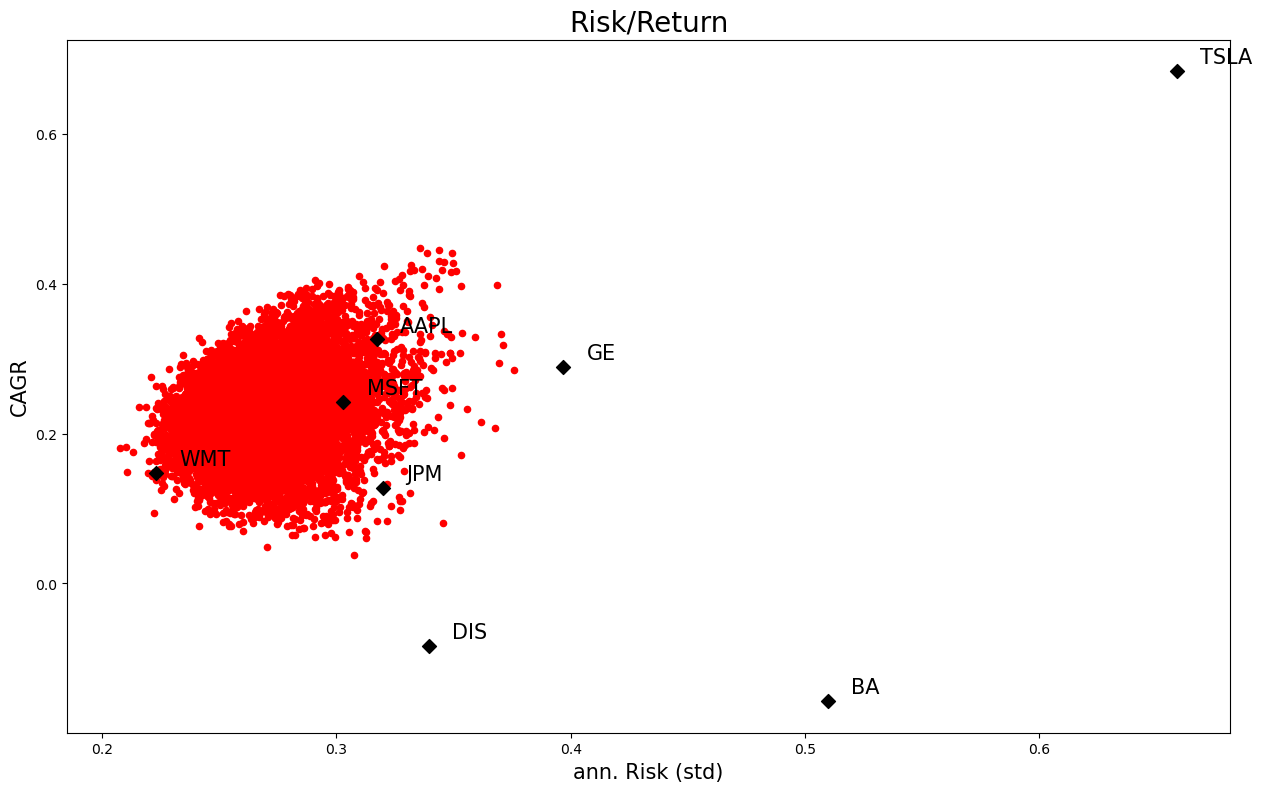

In [117]:
plt.figure(figsize = (15, 9))
plt.scatter(port_summary.loc[:, "ann. Risk"], port_summary.loc[:, "CAGR"],s= 20, color = "red")
plt.scatter(summary.loc[:, "ann. Risk"], summary.loc[:, "CAGR"], s= 50, color = "black", marker = "D")
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "ann. Risk"]+0.01, summary.loc[i, "CAGR"]+0.01), size = 15)
plt.xlabel("ann. Risk (std)", fontsize = 15)
plt.ylabel("CAGR", fontsize = 15)
plt.title("Risk/Return", fontsize = 20)
plt.show()

## Performance Measurement: Risk-adjusted Return

__Risk-adjusted-Return (RaR): CAGR per unit of Risk. (similar to Sharpe Ratio)__

In [124]:
summary["RaR"] = summary["CAGR"].div(summary["ann. Risk"])
summary

,ann. Risk,CAGR,RaR
Ticker,,,
AAPL,0.32,0.33,1.03
BA,0.51,-0.16,-0.31
DIS,0.34,-0.08,-0.25
GE,0.40,0.29,0.73
JPM,0.32,0.13,0.40
MSFT,0.30,0.24,0.80
TSLA,0.66,0.68,1.04
WMT,0.22,0.15,0.66


In [126]:
port_summary["RaR"] = port_summary["CAGR"].div(port_summary["ann. Risk"])
port_summary

,ann. Risk,CAGR,RaR
0,0.28,0.33,1.18
1,0.26,0.24,0.93
2,0.26,0.28,1.05
3,0.25,0.20,0.80
4,0.29,0.29,1.00
...,...,...,...
9995,0.31,0.27,0.88
9996,0.25,0.18,0.70
9997,0.28,0.30,1.07
9998,0.28,0.24,0.86


In [271]:
port_summary.sort_values("RaR")

,ann. Risk,CAGR,RaR
1451,0.3074,0.0375,0.1219
485,0.2703,0.0492,0.1821
9056,0.3125,0.0601,0.1924
6396,0.2994,0.0624,0.2084
4707,0.2907,0.0620,0.2131
...,...,...,...
9879,0.2779,0.3837,1.3809
4080,0.2793,0.3865,1.3840
912,0.2616,0.3639,1.3907
8674,0.2907,0.4046,1.3917


In [273]:
vmin = port_summary.RaR.min()
vmin

0.12187031875877764

In [275]:
vmax = port_summary.RaR.max()
vmax

1.3971406705301126

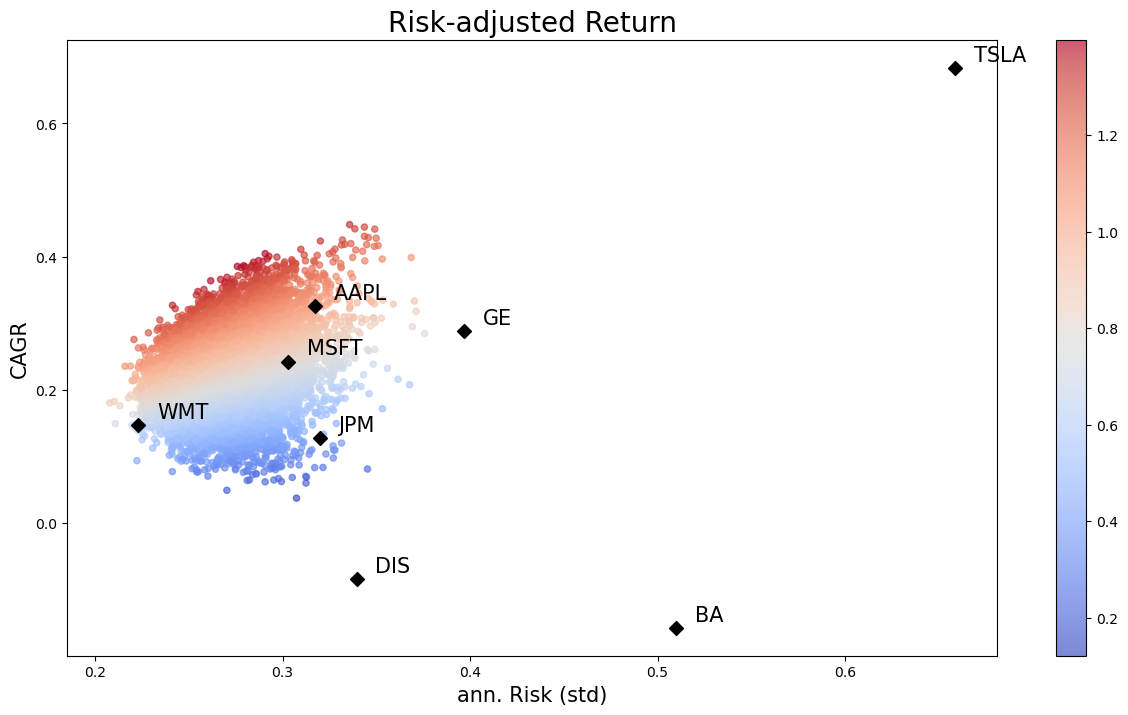

In [134]:
plt.figure(figsize = (15, 8))
plt.scatter(port_summary.loc[:, "ann. Risk"], port_summary.loc[:, "CAGR"], s= 20, 
            c = port_summary.loc[:, "RaR"], cmap = "coolwarm", vmin = vmin, vmax = vmax, alpha = 0.66)
plt.colorbar()
plt.scatter(summary.loc[:, "ann. Risk"], summary.loc[:, "CAGR"],s= 50, marker = "D", c = "black")
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "ann. Risk"]+0.01, summary.loc[i, "CAGR"]+0.01), size = 15)
plt.xlabel("ann. Risk (std)", fontsize = 15)
plt.ylabel("CAGR", fontsize = 15)
plt.title("Risk-adjusted Return", fontsize = 20)
plt.show()

## Portfolio Optimization

__Note: We are optimizing the past here (backward looking)!__

In [139]:
import scipy.optimize as sco
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(suppress = True)

In [140]:
returns 

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-10,0.0118,0.0299,-0.0219,0.0201,0.0127,-0.0105,0.0162,-0.0024
2019-09-11,0.0318,0.0364,0.0029,0.0241,0.0027,0.0003,0.0491,-0.0003
2019-09-12,-0.0022,-0.0191,0.0096,-0.0107,0.0061,0.0103,-0.0050,0.0078
2019-09-13,-0.0195,0.0110,0.0038,0.0086,0.0197,-0.0015,-0.0027,0.0044
2019-09-16,0.0053,-0.0024,-0.0161,0.0043,-0.0089,-0.0072,-0.0097,-0.0158
...,...,...,...,...,...,...,...,...
2024-08-30,-0.0034,0.0086,0.0063,0.0060,0.0117,0.0097,0.0380,0.0106
2024-09-03,-0.0272,-0.0732,-0.0138,-0.0596,-0.0200,-0.0185,-0.0164,-0.0008
2024-09-04,-0.0086,0.0137,0.0013,0.0131,-0.0044,-0.0013,0.0418,0.0009


In [141]:
#calculate portfolio CAGR (based on weights)
def port_ret(weights):
    simple_ret = returns.dot(weights.T)
    log_returns = np.log(simple_ret + 1)
    cagr = np.exp(log_returns.mean() * 252) - 1
    return cagr

In [142]:
#calculate annualized portfolio volatility (based on weights)
def port_vol(weights):
    simple_ret = returns.dot(weights.T)
    return simple_ret.std() * np.sqrt(252)

In [147]:
#define function to be minimized (sco only supports minimize, not maximize)
#-> maximize RaR == minimize RaR * (-1)
def min_func_RaR(weights): 
     return -(port_ret(weights)) / port_vol(weights) #Risk-adjusted Return * (-1)

In [149]:
#number of assets
noa = len(returns.columns)
noa

8

In [151]:
#equal weights (starting point of optimization)
eweigths = np.full(noa, 1/noa)
eweigths

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [153]:
#constraint: weights must sum up to 1 -> sum of weights - 1 = 0
cons = ({"type": "eq", "fun": lambda x: np.sum(x) - 1})



In [155]:
#bounds: all weights shall be between 0 and 1 -> can be changed
bnds =  tuple((0, 1) for x in range(noa))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [157]:
#run optimization based on function to be minimized, starting with equal weights and based on respective bounds and constraints
opts = sco.minimize(min_func_RaR, eweigths, method = "SLSQP", bounds = bnds, constraints= cons)

In [158]:
#output of optimization
opts

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.493740616206789
       x: [ 2.147e-01  0.000e+00  5.141e-16  2.288e-01  0.000e+00
            9.629e-18  2.432e-01  3.132e-01]
     nit: 9
     jac: [-7.451e-02  2.061e+00  1.394e+00 -7.489e-02  2.896e-01
            5.783e-02 -7.396e-02 -7.481e-02]
    nfev: 84
    njev: 9

In [160]:
#getting the optimal weights
optimal_weights = opts["x"]
optimal_weights

array([0.21469287, 0.        , 0.        , 0.22881827, 0.        ,
       0.        , 0.24324262, 0.31324624])

In [163]:
pd.Series(data = optimal_weights, index = returns.columns).sort_values(ascending = False).head(20)

Ticker
WMT    0.3132
TSLA   0.2432
GE     0.2288
AAPL   0.2147
DIS    0.0000
MSFT   0.0000
BA     0.0000
JPM    0.0000
dtype: float64

In [165]:
#cagr of the optimal portfolio
cagr_opt = port_ret(optimal_weights)
cagr_opt

0.4074688762149039

In [167]:
#volatility of the optimal portfolio
vol_opt = port_vol(optimal_weights)
vol_opt

0.27278422491425053

In [168]:
#RaR of the optimal portfolio
RaR_opt = -min_func_RaR(optimal_weights)
RaR_opt

1.493740616206789

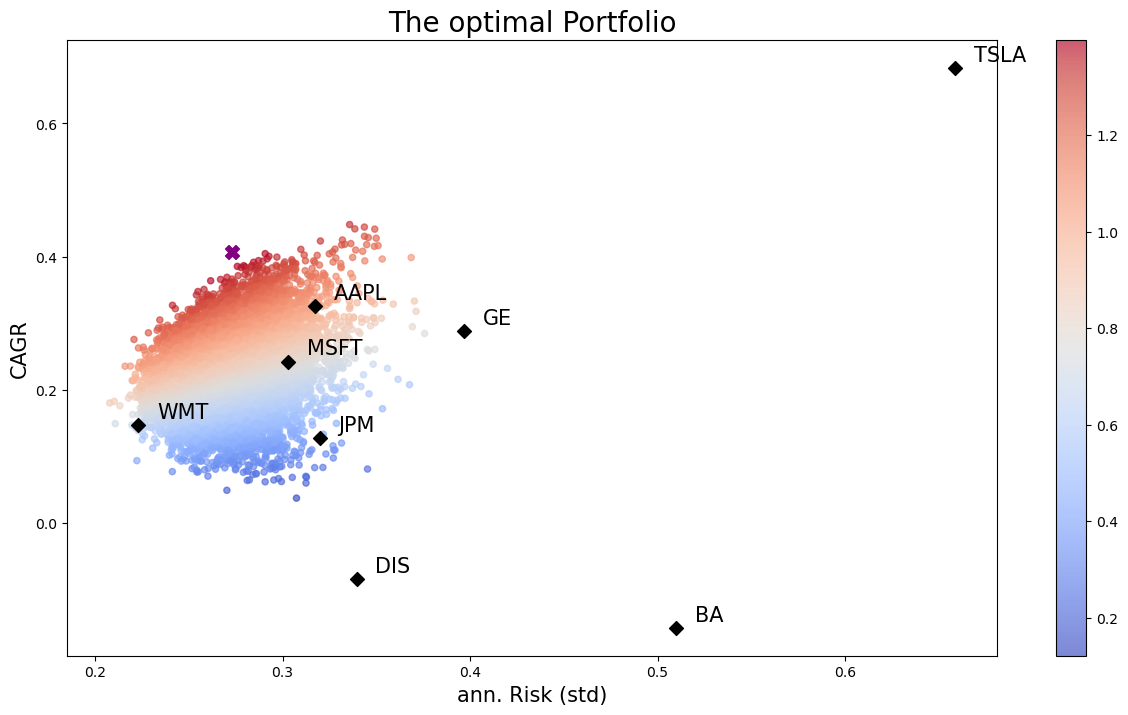

In [171]:
plt.figure(figsize = (15, 8))
plt.scatter(port_summary.loc[:, "ann. Risk"], port_summary.loc[:, "CAGR"], s= 20, 
            c = port_summary.loc[:, "RaR"], cmap = "coolwarm", vmin = vmin, vmax = vmax, alpha = 0.66)
plt.colorbar()
plt.scatter(summary.loc[:, "ann. Risk"], summary.loc[:, "CAGR"],s= 50, marker = "D", c = "black")
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "ann. Risk"]+0.01, summary.loc[i, "CAGR"]+0.01), size = 15)
plt.scatter(x = vol_opt, y = cagr_opt, s = 100, marker = "X", c = "purple") # best Portfolio
plt.xlabel("ann. Risk (std)", fontsize = 15)
plt.ylabel("CAGR", fontsize = 15)
plt.title("The optimal Portfolio", fontsize = 20)
plt.show()

## Minimum Variance Portfolio

(use code above with following replacements:)

In [177]:
# Minimum Variance Portfolio
opts = sco.minimize(port_vol, eweigths, method = "SLSQP", bounds = bnds, constraints= cons)

## Maximum Return Portfolio

(use code above with following replacements:)

In [182]:
#calculate portfolio CAGR (based on weights)
def port_ret(weights):
    simple_ret = returns.dot(weights.T)
    log_returns = np.log(simple_ret + 1)
    cagr = np.exp(log_returns.mean() * 252) - 1
    return cagr * (-1)

In [184]:
# Maximum Return Portfolio
opts = sco.minimize(port_ret, eweigths, method = "SLSQP", bounds = bnds, constraints= cons)

In [186]:
#cagr of the optimal portfolio
cagr_opt = -port_ret(optimal_weights)
cagr_opt

0.4074688762149039

## The Efficient Frontier

__Idea: Find for each return level the portfolio with the lowest volatility.__

In [191]:
returns

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-10,0.0118,0.0299,-0.0219,0.0201,0.0127,-0.0105,0.0162,-0.0024
2019-09-11,0.0318,0.0364,0.0029,0.0241,0.0027,0.0003,0.0491,-0.0003
2019-09-12,-0.0022,-0.0191,0.0096,-0.0107,0.0061,0.0103,-0.0050,0.0078
2019-09-13,-0.0195,0.0110,0.0038,0.0086,0.0197,-0.0015,-0.0027,0.0044
2019-09-16,0.0053,-0.0024,-0.0161,0.0043,-0.0089,-0.0072,-0.0097,-0.0158
...,...,...,...,...,...,...,...,...
2024-08-30,-0.0034,0.0086,0.0063,0.0060,0.0117,0.0097,0.0380,0.0106
2024-09-03,-0.0272,-0.0732,-0.0138,-0.0596,-0.0200,-0.0185,-0.0164,-0.0008
2024-09-04,-0.0086,0.0137,0.0013,0.0131,-0.0044,-0.0013,0.0418,0.0009


In [193]:
summary

,ann. Risk,CAGR,RaR
Ticker,,,
AAPL,0.3171,0.3257,1.0269
BA,0.5097,-0.1571,-0.3082
DIS,0.3395,-0.0835,-0.2459
GE,0.3968,0.2886,0.7274
JPM,0.3198,0.1274,0.3984
MSFT,0.3030,0.2426,0.8006
TSLA,0.6588,0.6837,1.0379
WMT,0.2230,0.1470,0.6593


In [195]:
#calculate portfolio CAGR (based on weights)
def port_ret(weights):
    simple_ret = returns.dot(weights.T).iloc[1:]
    log_returns = np.log(simple_ret + 1)
    cagr = np.exp(log_returns.mean() * 252) - 1
    return cagr

In [197]:
#calculate annualized portfolio volatility (based on weights)
def port_vol(weights):
    simple_ret = returns.dot(weights.T).iloc[1:]
    return simple_ret.std() * np.sqrt(252)

In [199]:
noa = len(returns.columns)
noa

8

In [201]:
#equal weights (starting point of optimization)
eweigths = np.full(noa, 1/noa)
eweigths

array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

In [203]:
tcagrs = np.linspace(summary.CAGR.min(), summary.CAGR.max(), 100)
tcagrs # evenly spaced target returns between min and max

array([-0.15711939, -0.1486261 , -0.14013281, -0.13163952, -0.12314623,
       -0.11465294, -0.10615966, -0.09766637, -0.08917308, -0.08067979,
       -0.0721865 , -0.06369321, -0.05519992, -0.04670663, -0.03821334,
       -0.02972005, -0.02122676, -0.01273347, -0.00424019,  0.0042531 ,
        0.01274639,  0.02123968,  0.02973297,  0.03822626,  0.04671955,
        0.05521284,  0.06370613,  0.07219942,  0.08069271,  0.089186  ,
        0.09767928,  0.10617257,  0.11466586,  0.12315915,  0.13165244,
        0.14014573,  0.14863902,  0.15713231,  0.1656256 ,  0.17411889,
        0.18261218,  0.19110547,  0.19959875,  0.20809204,  0.21658533,
        0.22507862,  0.23357191,  0.2420652 ,  0.25055849,  0.25905178,
        0.26754507,  0.27603836,  0.28453165,  0.29302494,  0.30151822,
        0.31001151,  0.3185048 ,  0.32699809,  0.33549138,  0.34398467,
        0.35247796,  0.36097125,  0.36946454,  0.37795783,  0.38645112,
        0.39494441,  0.40343769,  0.41193098,  0.42042427,  0.42

In [205]:
# portfolio return == tcagr
cons = ({"type": "eq", "fun": lambda x: port_ret(x) - tcagr},
       {"type": "eq", "fun": lambda x: np.sum(x) - 1})

In [207]:
bnds =  tuple((0, 1) for x in range(noa))
bnds

((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))

In [209]:
vols = []

In [211]:
#for each target return, find the portfolio with the lowest volatility
for tcagr in tcagrs:
    res = sco.minimize(port_vol, eweigths, method = "SLSQP", bounds = bnds, constraints = cons)
    vols.append(res["fun"])
vols = np.array(vols)

In [212]:
vols

array([0.509736  , 0.4910145 , 0.47183228, 0.45214866, 0.43192287,
       0.41112637, 0.38976116, 0.36794086, 0.3462487 , 0.33120724,
       0.32224306, 0.31339876, 0.30468699, 0.2961243 , 0.28772876,
       0.27952099, 0.27152478, 0.26376711, 0.25627857, 0.24909372,
       0.24225157, 0.23579585, 0.22977453, 0.22424016, 0.21925113,
       0.21486851, 0.21115689, 0.20812731, 0.20552369, 0.20332029,
       0.20152441, 0.20001855, 0.19876936, 0.19778093, 0.19701257,
       0.19643392, 0.19603294, 0.19581112, 0.19576751, 0.19590067,
       0.19619645, 0.19661389, 0.19714978, 0.19780252, 0.19856932,
       0.19952853, 0.20072434, 0.20215217, 0.20380073, 0.20567549,
       0.20776656, 0.21006801, 0.2125736 , 0.21528047, 0.21822813,
       0.22142243, 0.224856  , 0.22853713, 0.23246393, 0.23662838,
       0.24102338, 0.24564089, 0.25047424, 0.25551623, 0.2607603 ,
       0.26620028, 0.27183045, 0.27764556, 0.28364085, 0.28981206,
       0.29615541, 0.30266773, 0.30934593, 0.31618806, 0.32319

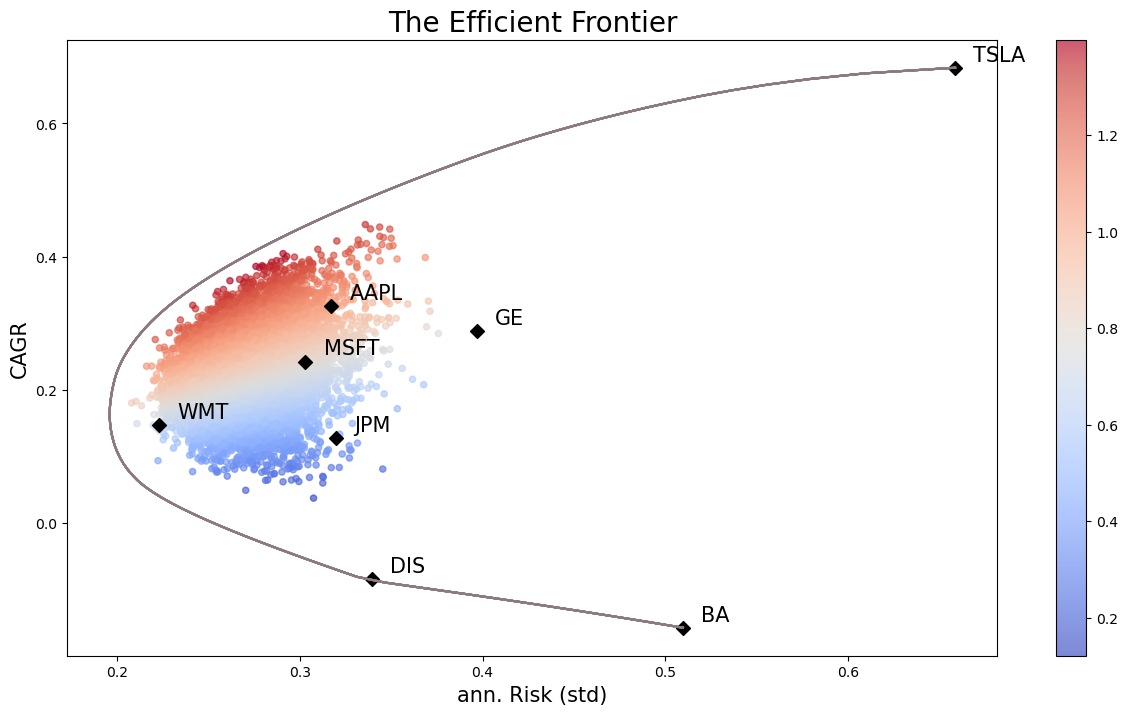

In [213]:
plt.figure(figsize = (15, 8))
plt.scatter(port_summary.loc[:, "ann. Risk"], port_summary.loc[:, "CAGR"], s= 20, 
            c = port_summary.loc[:, "RaR"], cmap = "coolwarm", vmin = vmin, vmax = vmax, alpha = 0.66)
plt.colorbar()
plt.scatter(summary.loc[:, "ann. Risk"], summary.loc[:, "CAGR"],s= 50, marker = "D", c = "black")
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "ann. Risk"]+0.01, summary.loc[i, "CAGR"]+0.01), size = 15)
    plt.plot(vols, tcagrs) # efficient frontier

plt.xlabel("ann. Risk (std)", fontsize = 15)
plt.ylabel("CAGR", fontsize = 15)
plt.title("The Efficient Frontier", fontsize = 20)
plt.show()

## Comparison: daily Rebalancing vs. no Rebalancing

__Efficient Frontier without rebalancing:__

In [217]:
cagr_no = np.array([-0.21321957, -0.20504081, -0.19686206, -0.18868331, -0.18050455,
       -0.1723258 , -0.16414704, -0.15596829, -0.14778953, -0.13961078,
       -0.13143202, -0.12325327, -0.11507451, -0.10689576, -0.098717  ,
       -0.09053825, -0.08235949, -0.07418074, -0.06600198, -0.05782323,
       -0.04964447, -0.04146572, -0.03328696, -0.02510821, -0.01692945,
       -0.0087507 , -0.00057194,  0.00760681,  0.01578557,  0.02396432,
        0.03214308,  0.04032183,  0.04850058,  0.05667934,  0.06485809,
        0.07303685,  0.0812156 ,  0.08939436,  0.09757311,  0.10575187,
        0.11393062,  0.12210938,  0.13028813,  0.13846689,  0.14664564,
        0.1548244 ,  0.16300315,  0.17118191,  0.17936066,  0.18753942,
        0.19571817,  0.20389693,  0.21207568,  0.22025444,  0.22843319,
        0.23661195,  0.2447907 ,  0.25296946,  0.26114821,  0.26932697,
        0.27750572,  0.28568448,  0.29386323,  0.30204198,  0.31022074,
        0.31839949,  0.32657825,  0.334757  ,  0.34293576,  0.35111451,
        0.35929327,  0.36747202,  0.37565078,  0.38382953,  0.39200829,
        0.40018704,  0.4083658 ,  0.41654455,  0.42472331,  0.43290206,
        0.44108082,  0.44925957,  0.45743833,  0.46561708,  0.47379584,
        0.48197459,  0.49015335,  0.4983321 ,  0.50651086,  0.51468961,
        0.52286837,  0.53104712,  0.53922587,  0.54740463,  0.55558338,
        0.56376214,  0.57194089,  0.58011965,  0.5882984 ,  0.59647716])

In [218]:
vols_no = np.array([0.43230733, 0.4082562 , 0.38776821, 0.36971057, 0.35298005,
       0.33746244, 0.32307554, 0.30974812, 0.29741952, 0.28603623,
       0.27555009, 0.26591947, 0.25710661, 0.2490747 , 0.24178985,
       0.23521878, 0.22932929, 0.22408966, 0.2194684 , 0.21543409,
       0.2119554 , 0.20898808, 0.2064256 , 0.20423296, 0.20239196,
       0.20088063, 0.19967245, 0.19867169, 0.19785033, 0.19719909,
       0.19670841, 0.19636225, 0.19615204, 0.19607055, 0.19611186,
       0.19626816, 0.19653368, 0.19690195, 0.19736735, 0.19792419,
       0.19867678, 0.19968965, 0.20093869, 0.20241949, 0.20410759,
       0.20598642, 0.20804255, 0.21026158, 0.2126309 , 0.21513937,
       0.21779366, 0.22060839, 0.22356945, 0.22680792, 0.23038234,
       0.23426203, 0.23842321, 0.24284222, 0.2474965 , 0.25236585,
       0.25743184, 0.2626779 , 0.26808938, 0.273651  , 0.27935259,
       0.28518299, 0.29113258, 0.29719306, 0.30335721, 0.30961907,
       0.31597335, 0.32252773, 0.32942379, 0.33662063, 0.34408425,
       0.3517883 , 0.35971312, 0.36784493, 0.37617501, 0.3846992 ,
       0.39341798, 0.40233485, 0.41145694, 0.42079451, 0.4303609 ,
       0.44017233, 0.45024792, 0.46060983, 0.47132985, 0.48248702,
       0.4941349 , 0.50633574, 0.51916219, 0.53269957, 0.54704879,
       0.56233037, 0.57869002, 0.59630658, 0.61540303, 0.63626358])

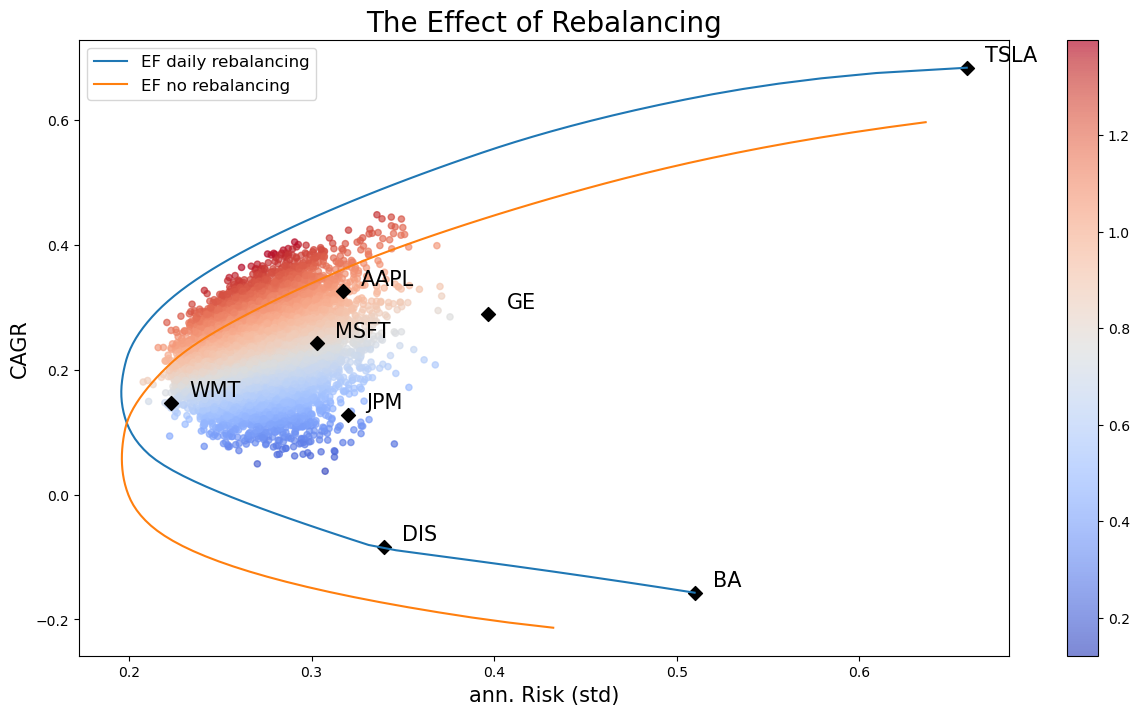

In [219]:
plt.figure(figsize = (15, 8))
plt.scatter(port_summary.loc[:, "ann. Risk"], port_summary.loc[:, "CAGR"], s= 20, 
            c = port_summary.loc[:, "RaR"], cmap = "coolwarm", vmin = vmin, vmax = vmax, alpha = 0.66)
plt.colorbar()
plt.scatter(summary.loc[:, "ann. Risk"], summary.loc[:, "CAGR"],s= 50, marker = "D", c = "black")
for i in summary.index:
    plt.annotate(i, xy=(summary.loc[i, "ann. Risk"]+0.01, summary.loc[i, "CAGR"]+0.01), size = 15)
plt.plot(vols, tcagrs, label = "EF daily rebalancing") # efficient frontier with rebal.
plt.plot(vols_no, cagr_no, label = "EF no rebalancing") # efficient frontier without rebal.
plt.xlabel("ann. Risk (std)", fontsize = 15)
plt.ylabel("CAGR", fontsize = 15)
plt.legend(fontsize = 12)
plt.title("The Effect of Rebalancing", fontsize = 20)
plt.show()

## Bonus!!! Approximation of Rebalancing Costs

In [225]:
w1 # target weights to be reinstated at the end of each day 

array([0.15243548, 0.06262702, 0.04965074, 0.12066568, 0.15746942,
       0.09260487, 0.21465883, 0.14988797])

In [226]:
returns

Ticker,AAPL,BA,DIS,GE,JPM,MSFT,TSLA,WMT
Date,,,,,,,,
2019-09-10,0.0118,0.0299,-0.0219,0.0201,0.0127,-0.0105,0.0162,-0.0024
2019-09-11,0.0318,0.0364,0.0029,0.0241,0.0027,0.0003,0.0491,-0.0003
2019-09-12,-0.0022,-0.0191,0.0096,-0.0107,0.0061,0.0103,-0.0050,0.0078
2019-09-13,-0.0195,0.0110,0.0038,0.0086,0.0197,-0.0015,-0.0027,0.0044
2019-09-16,0.0053,-0.0024,-0.0161,0.0043,-0.0089,-0.0072,-0.0097,-0.0158
...,...,...,...,...,...,...,...,...
2024-08-30,-0.0034,0.0086,0.0063,0.0060,0.0117,0.0097,0.0380,0.0106
2024-09-03,-0.0272,-0.0732,-0.0138,-0.0596,-0.0200,-0.0185,-0.0164,-0.0008
2024-09-04,-0.0086,0.0137,0.0013,0.0131,-0.0044,-0.0013,0.0418,0.0009


In [227]:
matrix = returns.add(1).mul(w1).values
matrix

array([[0.15423621, 0.0644965 , 0.04856352, ..., 0.09163518, 0.21813167,
        0.14952719],
       [0.15728218, 0.06490674, 0.049797  , ..., 0.09263208, 0.225194  ,
        0.14984921],
       [0.1520946 , 0.06143152, 0.05012832, ..., 0.09355732, 0.2135903 ,
        0.15105069],
       ...,
       [0.15112168, 0.06348268, 0.04971759, ..., 0.09248273, 0.22363862,
        0.15002393],
       [0.15349152, 0.06221646, 0.04931695, ..., 0.09248937, 0.22518582,
        0.14934461],
       [0.15136614, 0.0608774 , 0.04925309, ..., 0.09108787, 0.19652889,
        0.14926473]])

In [228]:
weights = matrix / matrix.sum(axis = 1, keepdims= True)
weights # weights at the end of each day (before rebalancing)

array([[0.15283693, 0.06391137, 0.04812294, ..., 0.09080384, 0.21615272,
        0.14817063],
       [0.15402729, 0.06356352, 0.04876647, ..., 0.0907151 , 0.22053371,
        0.14674814],
       [0.15214539, 0.06145203, 0.05014507, ..., 0.09358856, 0.21366163,
        0.15110113],
       ...,
       [0.14970119, 0.06288597, 0.04925026, ..., 0.09161343, 0.22153649,
        0.14861375],
       [0.15240355, 0.06177546, 0.04896739, ..., 0.09183379, 0.22358967,
        0.14828604],
       [0.15591209, 0.06270572, 0.05073229, ..., 0.09382349, 0.20243119,
        0.15374756]])

In [229]:
weights.shape

(1257, 8)

In [230]:
weights.sum(axis = 1)

array([1., 1., 1., ..., 1., 1., 1.])

In [231]:
delta_weights = weights - w1
delta_weights

array([[ 0.00040145,  0.00128436, -0.0015278 , ..., -0.00180103,
         0.00149389, -0.00171733],
       [ 0.00159181,  0.0009365 , -0.00088427, ..., -0.00188977,
         0.00587487, -0.00313982],
       [-0.00029009, -0.00117498,  0.00049433, ...,  0.00098369,
        -0.0009972 ,  0.00121316],
       ...,
       [-0.00273429,  0.00025895, -0.00040048, ..., -0.00099144,
         0.00687766, -0.00127421],
       [-0.00003193, -0.00085156, -0.00068335, ..., -0.00077107,
         0.00893084, -0.00160193],
       [ 0.00347661,  0.0000787 ,  0.00108155, ...,  0.00121862,
        -0.01222764,  0.0038596 ]])

In [232]:
np.abs(delta_weights)

array([[0.00040145, 0.00128436, 0.0015278 , ..., 0.00180103, 0.00149389,
        0.00171733],
       [0.00159181, 0.0009365 , 0.00088427, ..., 0.00188977, 0.00587487,
        0.00313982],
       [0.00029009, 0.00117498, 0.00049433, ..., 0.00098369, 0.0009972 ,
        0.00121316],
       ...,
       [0.00273429, 0.00025895, 0.00040048, ..., 0.00099144, 0.00687766,
        0.00127421],
       [0.00003193, 0.00085156, 0.00068335, ..., 0.00077107, 0.00893084,
        0.00160193],
       [0.00347661, 0.0000787 , 0.00108155, ..., 0.00121862, 0.01222764,
        0.0038596 ]])

In [233]:
df = pd.DataFrame(np.abs(delta_weights))
df # deviation of weights

,0,1,2,3,4,5,6,7
0,0.0004,0.0013,0.0015,0.0013,0.0006,0.0018,0.0015,0.0017
1,0.0016,0.0009,0.0009,0.0003,0.0028,0.0019,0.0059,0.0031
2,0.0003,0.0012,0.0005,0.0012,0.0010,0.0010,0.0010,0.0012
3,0.0033,0.0006,0.0001,0.0008,0.0028,0.0003,0.0010,0.0004
4,0.0018,0.0002,0.0005,0.0013,0.0004,0.0001,0.0008,0.0015
...,...,...,...,...,...,...,...,...
1252,0.0026,0.0003,0.0004,0.0009,0.0003,0.0003,0.0052,0.0004
1253,0.0003,0.0031,0.0006,0.0043,0.0008,0.0006,0.0019,0.0037
1254,0.0027,0.0003,0.0004,0.0004,0.0022,0.0010,0.0069,0.0013
1255,0.0000,0.0009,0.0007,0.0027,0.0023,0.0008,0.0089,0.0016


In [234]:
daily_rebal = df.sum(axis = 1).mean()
daily_rebal

0.013840495548592386

__-> on average, approx. 1.5% of total portfolio needs to be rebalanced every day (fractional trading).__

In [236]:
ptc = 0.01 # worst case for US Stocks
ptc

0.01

In [237]:
daily_ptc = daily_rebal * ptc
daily_ptc

0.00013840495548592387

In [238]:
port1

Date
2019-09-10    0.0092
2019-09-11    0.0211
2019-09-12   -0.0003
2019-09-13    0.0020
2019-09-16   -0.0062
               ...  
2024-08-30    0.0135
2024-09-03   -0.0251
2024-09-04    0.0095
2024-09-05    0.0071
2024-09-06   -0.0292
Length: 1257, dtype: float64

In [239]:
port1_ac = port1 - daily_ptc
port1_ac

Date
2019-09-10    0.0090
2019-09-11    0.0210
2019-09-12   -0.0005
2019-09-13    0.0018
2019-09-16   -0.0063
               ...  
2024-08-30    0.0134
2024-09-03   -0.0252
2024-09-04    0.0094
2024-09-05    0.0070
2024-09-06   -0.0293
Length: 1257, dtype: float64

In [240]:
ann_risk_return(port1.to_frame())

,ann. Risk,CAGR
0,0.2783,0.3273


In [241]:
ann_risk_return(port1_ac.to_frame())

,ann. Risk,CAGR
0,0.2783,0.2818
